# Лабораторна робота 4

# Satellite Image Classification

![](https://cff2.earth.com/uploads/2019/08/09193739/satellite-67718_1280-960x640.jpg)

[Image Source](https://www.earth.com/earthpedia-articles/how-many-satellites-in-space-do-we-know-about/)

The "Satellite Image Classification" dataset on Kaggle is a collection of satellite images labeled with classes such as "Cloudy", "Desert", "Green_Area", and "Water". The data is made up of satellite images of size 256x256, and can be used for computer vision tasks such as image classification.

# Satellite Image Classification Model

---

# GPU Being Used:

In [1]:
!nvidia-smi

Fri Jun  9 15:59:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

# Data Pre-processing:

In [2]:
import pandas as pd
from pathlib import Path
import os

DATA_DIR = Path.cwd() / "kaggle" / "working"
# Create an empty dataframe
data = pd.DataFrame(columns=['image_path', 'label'])

# Define the labels/classes
labels = {'/kaggle/input/satellite-image-classification/data/cloudy' : 'Cloudy',
          '/kaggle/input/satellite-image-classification/data/desert' : 'Desert',
          '/kaggle/input/satellite-image-classification/data/green_area' : 'Green_Area',
          '/kaggle/input/satellite-image-classification/data/water' : 'Water',
           }

In [3]:
# Loop over the train, test, and val folders and extract the image path and label
for folder in labels:
    for image_name in os.listdir(folder):
        image_path = os.path.join(folder, image_name)
        label = labels[folder]
        data = data.append({'image_path': image_path, 'label': label}, ignore_index=True)

In [4]:
# Save the data to a CSV file
data.to_csv('image_dataset.csv', index=False)

In [14]:
import multiprocessing as mp

import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

RS = 42

tf.random.set_seed(RS)

In [6]:
# Load the dataset
df = pd.read_csv("/kaggle/working/image_dataset.csv")

In [7]:
df

,image_path,label
0,/kaggle/input/satellite-image-classification/d...,Cloudy
1,/kaggle/input/satellite-image-classification/d...,Cloudy
2,/kaggle/input/satellite-image-classification/d...,Cloudy
3,/kaggle/input/satellite-image-classification/d...,Cloudy
4,/kaggle/input/satellite-image-classification/d...,Cloudy
...,...,...
5626,/kaggle/input/satellite-image-classification/d...,Water
5627,/kaggle/input/satellite-image-classification/d...,Water
5628,/kaggle/input/satellite-image-classification/d...,Water
5629,/kaggle/input/satellite-image-classification/d...,Water


In [8]:
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=RS)
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=RS)
train_df.shape, valid_df.shape, test_df.shape

((3603, 2), (901, 2), (1127, 2))

In [9]:
# Pre-process the data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=45,
                                   vertical_flip=True,
                                   fill_mode='nearest')


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col="image_path",
                                                    y_col="label",
                                                    target_size=(255, 255),
                                                    batch_size=32,
                                                    class_mode="categorical")

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                  x_col="image_path",
                                                  y_col="label",
                                                  target_size=(255, 255),
                                                  batch_size=32,
                                                  class_mode="categorical")

valid_generator = test_datagen.flow_from_dataframe(dataframe=valid_df,
                                                  x_col="image_path",
                                                  y_col="label",
                                                  target_size=(255, 255),
                                                  batch_size=32,
                                                  class_mode="categorical")

Found 3603 validated image filenames belonging to 4 classes.
Found 1127 validated image filenames belonging to 4 classes.
Found 901 validated image filenames belonging to 4 classes.


# Deep Learning Model

In [10]:
from time import perf_counter

import keras
import matplotlib.pyplot as plt

In [11]:
def plot_metric(history: keras.callbacks.History, metric: str, k: int = 5) -> None:

    assert metric in ['accuracy', 'loss'], "Wrong type of metric. Just use 'accuracy' or 'loss'"
    
    train_metrics = history.history[metric]
    val_metrics = history.history[f'val_{metric}']
    epochs = range(1, len(train_metrics) + 1)
    
    plt.plot(epochs, train_metrics, '-o', markersize=3, label=f"Training {metric}")
    plt.plot(epochs, val_metrics, label=f"Validation {metric}")
    
    plt.xticks([1] + [i for i in epochs if i % k == 0])
    
    plt.title(f'Training and validation {metric}')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend()
    plt.show()
    

def build_train_eval_plot(
    train_generator, valid_generator, test_generator, nn_architecture: str,
    batch_size: int, epochs: int, optimizer: str, lr: float = 0.001
) -> dict:

    assert optimizer in ("Adam", "SGD", "RMSprop")
    
    opt = {
        "Adam": keras.optimizers.Adam(learning_rate=lr),
        "SGD": keras.optimizers.SGD(learning_rate=lr),
        "RMSprop": keras.optimizers.RMSprop(learning_rate=lr),
    }
    
    cnn = model_CNN()
    cnn.compile(optimizer=opt[optimizer], loss='categorical_crossentropy', metrics=['accuracy'])
    cnn.summary()
    
    suffix_name = f"layers-{len(cnn.layers)}_opt-{optimizer}_lr-{lr}_{nn_architecture}"
    checkpoint_name = f"best-CNN_{suffix_name}.hdf5"
    checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', 
                                 verbose=1, save_best_only=True, save_freq='epoch')
    
    time1 = perf_counter()
    history = cnn.fit(train_generator, validation_data=valid_generator, 
                      batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], 
                      use_multiprocessing=True, workers=mp.cpu_count(), verbose=1)
    time_to_train = perf_counter() - time1
    
    plot_metric(history, 'loss', k=1)
    plot_metric(history, 'accuracy', k=1)
    
    cnn = load_model(checkpoint_name)
    
    time1 = perf_counter()
    print("\nEval scores:")
    loss, acc = cnn.evaluate(test_generator, batch_size=batch_size)
    time_to_eval = perf_counter() - time1
    
    print(f"================ {Path(checkpoint_name).stem} ================")
    print(f"batch_size: {batch_size} | epoch: {epochs}")
    print(f"Time to train model: {time_to_train:.2f} sec")
    print(f"Time to eval model: {time_to_eval:.2f} sec")
    
    return {
        "optimizer": optimizer,
        "lr": lr,
        "loss": loss,
        "accuracy": acc,
        "batch_size": batch_size,
        "epochs": epochs,
        "nn_architecture": nn_architecture,
        "time_eval": time_to_eval,
        "time_train": time_to_train
    }

In [12]:
def model_CNN():
    # Build a deep learning model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(255, 255, 3), activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 253, 253, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 251, 251, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 123, 123, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 59, 59, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 128)       0

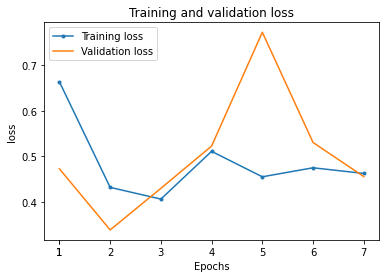

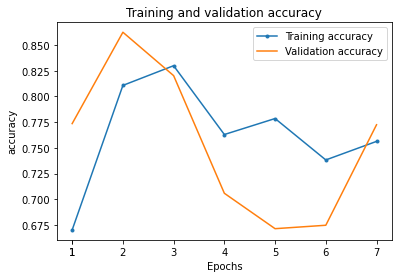


Eval scores:
36/36 [==============================] - 10s 266ms/step - loss: 0.3302 - accuracy: 0.8589
================ best-CNN_layers-11_opt-Adam_lr-0.001_default ================
batch_size: 32 | epoch: 7
Time to train model: 495.19 sec
Time to eval model: 10.20 sec


In [15]:
trial1 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'default', 32, 7, 'Adam', 0.001)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 253, 253, 32)      896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 251, 251, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 123, 123, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 59, 59, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 29, 29, 128)      

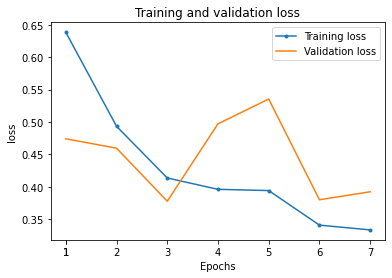

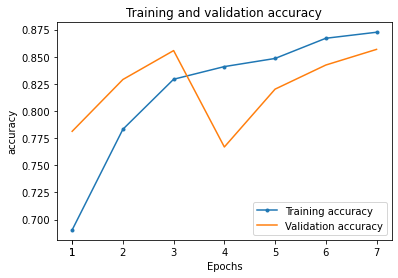


Eval scores:
36/36 [==============================] - 4s 110ms/step - loss: 0.3839 - accuracy: 0.8492
================ best-CNN_layers-11_opt-Adam_lr-0.001_default ================
batch_size: 64 | epoch: 7
Time to train model: 498.15 sec
Time to eval model: 5.41 sec


In [17]:
trial2 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'default', 64, 7, 'Adam', 0.001)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 253, 253, 32)      896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 251, 251, 32)      9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 123, 123, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 59, 59, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 29, 29, 128)      

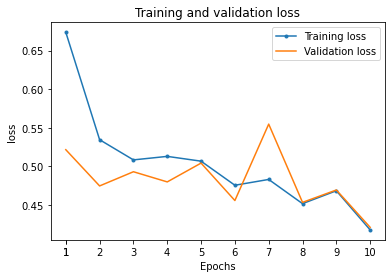

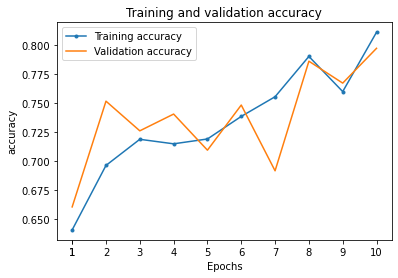


Eval scores:
36/36 [==============================] - 4s 111ms/step - loss: 0.4218 - accuracy: 0.8012
================ best-CNN_layers-11_opt-Adam_lr-0.001_default ================
batch_size: 32 | epoch: 10
Time to train model: 726.90 sec
Time to eval model: 4.64 sec


In [18]:
trial3 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'default', 32, 10, 'Adam', 0.001)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 253, 253, 32)      896       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 251, 251, 32)      9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 123, 123, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 59, 59, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 29, 29, 128)      

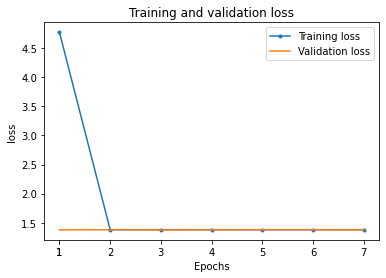

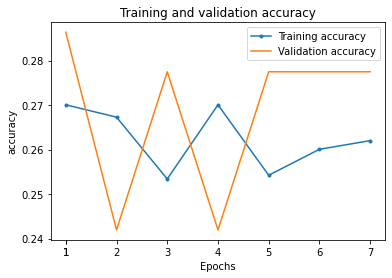


Eval scores:
36/36 [==============================] - 5s 124ms/step - loss: 1.3820 - accuracy: 0.2520
================ best-CNN_layers-11_opt-Adam_lr-0.01_default ================
batch_size: 32 | epoch: 7
Time to train model: 459.18 sec
Time to eval model: 5.56 sec


In [19]:
trial4 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'default', 32, 7, 'Adam', 0.01)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 253, 253, 32)      896       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 251, 251, 32)      9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 123, 123, 64)      18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 59, 59, 128)       73856     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 29, 29, 128)      

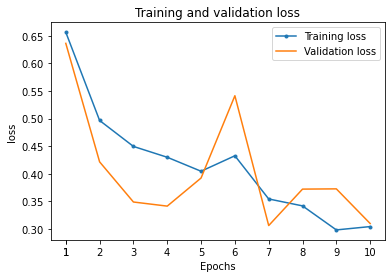

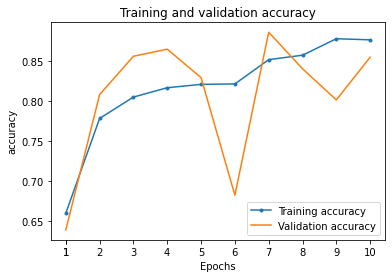


Eval scores:
36/36 [==============================] - 5s 142ms/step - loss: 0.2797 - accuracy: 0.8900
================ best-CNN_layers-11_opt-Adam_lr-0.001_default ================
batch_size: 64 | epoch: 10
Time to train model: 695.35 sec
Time to eval model: 10.70 sec


In [20]:
trial5 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'default', 64, 10, 'Adam', 0.001)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 253, 253, 32)      896       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 251, 251, 32)      9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 123, 123, 64)      18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 59, 59, 128)       73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 29, 29, 128)      

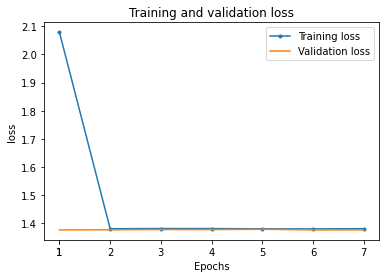

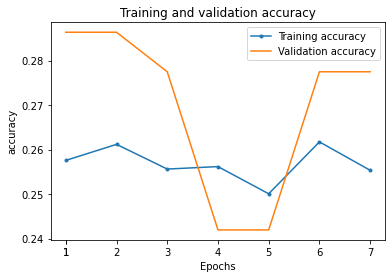


Eval scores:
36/36 [==============================] - 4s 106ms/step - loss: 1.3810 - accuracy: 0.2520
================ best-CNN_layers-11_opt-Adam_lr-0.01_default ================
batch_size: 64 | epoch: 7
Time to train model: 473.33 sec
Time to eval model: 4.15 sec


In [21]:
trial6 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'default', 64, 7, 'Adam', 0.01)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 253, 253, 32)      896       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 251, 251, 32)      9248      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 123, 123, 64)      18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 59, 59, 128)       73856     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 29, 29, 128)      

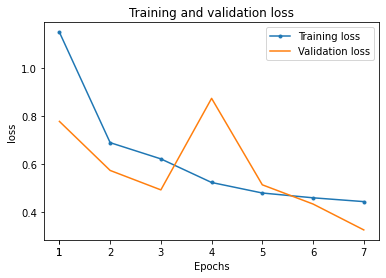

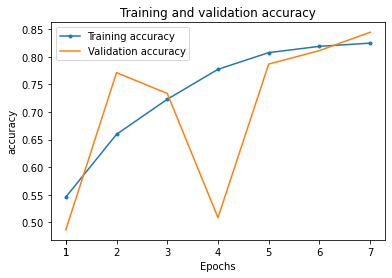


Eval scores:
36/36 [==============================] - 5s 128ms/step - loss: 0.3240 - accuracy: 0.8492
================ best-CNN_layers-11_opt-RMSprop_lr-0.001_default ================
batch_size: 32 | epoch: 7
Time to train model: 498.18 sec
Time to eval model: 5.62 sec


In [22]:
trial7 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'default', 32, 7, 'RMSprop', 0.001)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 253, 253, 32)      896       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 251, 251, 32)      9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 123, 123, 64)      18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 59, 59, 128)       73856     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 29, 29, 128)      

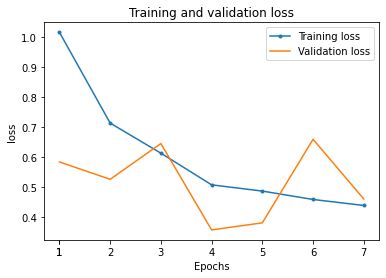

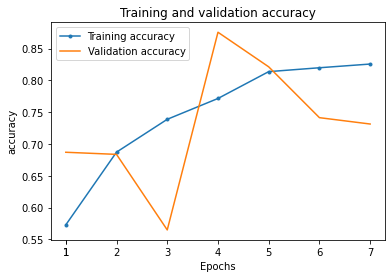


Eval scores:
36/36 [==============================] - 4s 99ms/step - loss: 0.3354 - accuracy: 0.8811
================ best-CNN_layers-11_opt-RMSprop_lr-0.001_default ================
batch_size: 64 | epoch: 7
Time to train model: 501.06 sec
Time to eval model: 5.40 sec


In [23]:
trial8 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'default', 64, 7, 'RMSprop', 0.001)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 253, 253, 32)      896       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 251, 251, 32)      9248      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 123, 123, 64)      18496     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 59, 59, 128)       73856     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 29, 29, 128)      

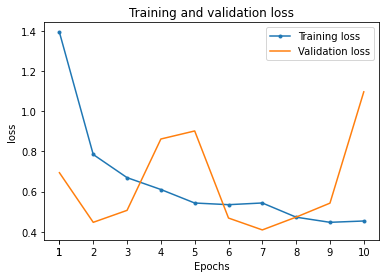

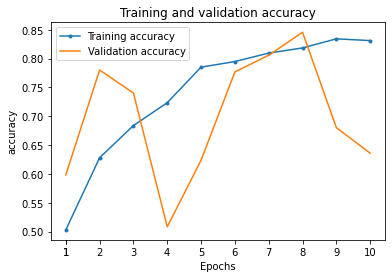


Eval scores:
36/36 [==============================] - 5s 116ms/step - loss: 0.3992 - accuracy: 0.8181
================ best-CNN_layers-11_opt-RMSprop_lr-0.001_default ================
batch_size: 32 | epoch: 10
Time to train model: 653.67 sec
Time to eval model: 5.67 sec


In [24]:
trial9 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'default', 32, 10, 'RMSprop', 0.001)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 253, 253, 32)      896       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 251, 251, 32)      9248      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 123, 123, 64)      18496     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 59, 59, 128)       73856     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 29, 29, 128)     

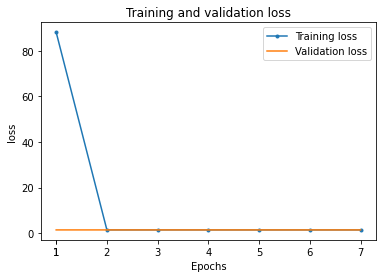

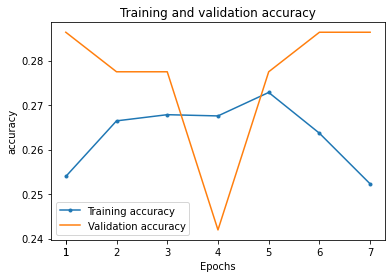


Eval scores:
36/36 [==============================] - 4s 109ms/step - loss: 1.3822 - accuracy: 0.2520
================ best-CNN_layers-11_opt-RMSprop_lr-0.01_default ================
batch_size: 32 | epoch: 7
Time to train model: 477.29 sec
Time to eval model: 4.67 sec


In [25]:
trial10 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'default', 32, 7, 'RMSprop', 0.01)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 253, 253, 32)      896       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 251, 251, 32)      9248      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 123, 123, 64)      18496     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 59, 59, 128)       73856     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 29, 29, 128)     

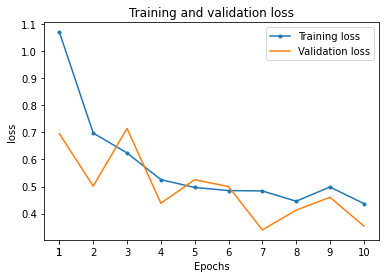

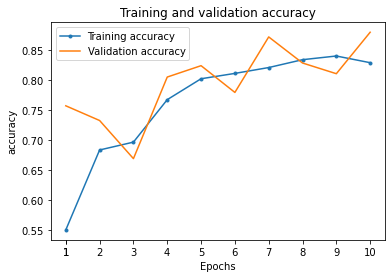


Eval scores:
36/36 [==============================] - 4s 96ms/step - loss: 0.3207 - accuracy: 0.8713
================ best-CNN_layers-11_opt-RMSprop_lr-0.001_default ================
batch_size: 64 | epoch: 10
Time to train model: 675.31 sec
Time to eval model: 5.38 sec


In [26]:
trial11 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'default', 64, 10, 'RMSprop', 0.001)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 253, 253, 32)      896       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 251, 251, 32)      9248      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 123, 123, 64)      18496     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 59, 59, 128)       73856     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 29, 29, 128)     

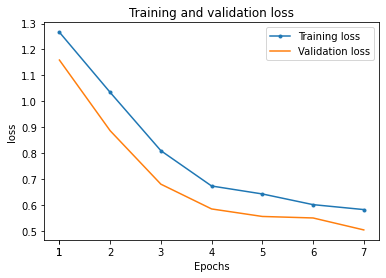

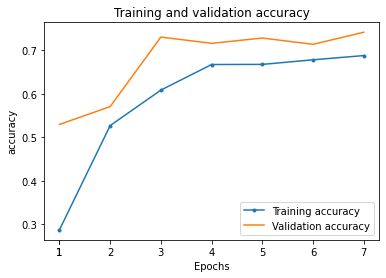


Eval scores:
36/36 [==============================] - 5s 119ms/step - loss: 0.4711 - accuracy: 0.7720
================ best-CNN_layers-11_opt-SGD_lr-0.001_default ================
batch_size: 32 | epoch: 7
Time to train model: 499.54 sec
Time to eval model: 5.52 sec


In [27]:
trial12 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'default', 32, 7, 'SGD', 0.001)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 253, 253, 32)      896       
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 251, 251, 32)      9248      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 123, 123, 64)      18496     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 59, 59, 128)       73856     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 29, 29, 128)     

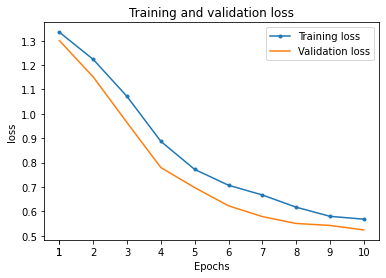

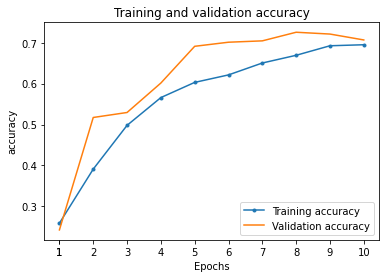


Eval scores:
36/36 [==============================] - 5s 135ms/step - loss: 0.4840 - accuracy: 0.7365
================ best-CNN_layers-11_opt-SGD_lr-0.001_default ================
batch_size: 32 | epoch: 10
Time to train model: 685.12 sec
Time to eval model: 5.52 sec


In [28]:
trial13 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'default', 32, 10, 'SGD', 0.001)

In [29]:
def model_CNN():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=(255, 255, 3), activation='relu'))  # Increase the number of filters
    model.add(BatchNormalization())  # Add Batch Normalization layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, (3, 3), activation='relu'))  # Increase the number of filters
    model.add(BatchNormalization())  # Add Batch Normalization layer
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(256, (3, 3), activation='relu'))  # Increase the number of filters
    model.add(MaxPooling2D(2, 2))
#     model.add(Flatten())
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))  # Increase the number of neurons in the Dense layer
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))  # Add an extra Dense layer
    model.add(Dense(4, activation='softmax'))
    return model

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 253, 253, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 253, 253, 64)      256       
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 251, 251, 64)      36928     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 125, 125, 64)      0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 123, 123, 128)     73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 123, 123, 128)     512       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 61, 61, 128)     

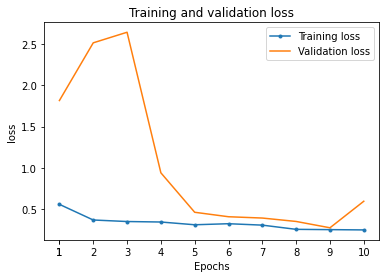

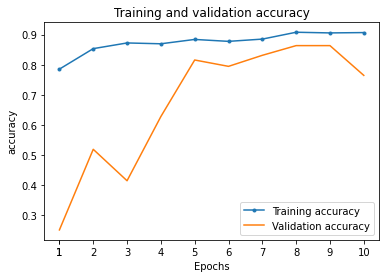


Eval scores:
36/36 [==============================] - 6s 155ms/step - loss: 0.2558 - accuracy: 0.8696
================ best-CNN_layers-14_opt-Adam_lr-0.001_more_complex_with_flatten ================
batch_size: 32 | epoch: 10
Time to train model: 713.73 sec
Time to eval model: 6.30 sec


In [30]:
trial14 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'more_complex_with_flatten', 32, 10, 'Adam', 0.001)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 253, 253, 64)      1792      
_________________________________________________________________
batch_normalization_2 (Batch (None, 253, 253, 64)      256       
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 251, 251, 64)      36928     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 125, 125, 64)      0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 123, 123, 128)     73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 123, 123, 128)     512       
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 61, 61, 128)     

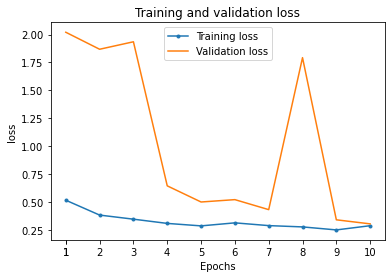

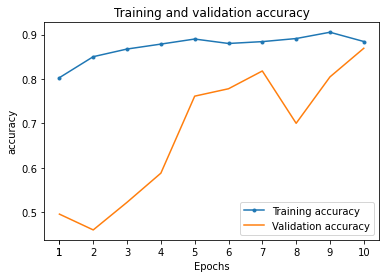


Eval scores:
36/36 [==============================] - 6s 141ms/step - loss: 0.2591 - accuracy: 0.8713
================ best-CNN_layers-14_opt-Adam_lr-0.001_more_complex_with_GlobalAveragePooling2D ================
batch_size: 32 | epoch: 10
Time to train model: 712.97 sec
Time to eval model: 5.91 sec


In [31]:
trial15 = build_train_eval_plot(train_generator, valid_generator, test_generator, 'more_complex_with_GlobalAveragePooling2D', 32, 10, 'Adam', 0.001)

In [33]:
model = load_model('/kaggle/working/best-CNN_layers-11_opt-Adam_lr-0.001_default.hdf5')

In [35]:
history = model.fit(train_generator, validation_data=valid_generator, epochs=5,
                    use_multiprocessing=True, workers=mp.cpu_count())

Epoch 1/5
113/113 [==============================] - 59s 503ms/step - loss: 0.3206 - accuracy: 0.8676 - val_loss: 0.3444 - val_accuracy: 0.8457
Epoch 2/5
113/113 [==============================] - 65s 551ms/step - loss: 0.3505 - accuracy: 0.8487 - val_loss: 0.3364 - val_accuracy: 0.8491
Epoch 3/5
113/113 [==============================] - 58s 503ms/step - loss: 0.3103 - accuracy: 0.8690 - val_loss: 0.3848 - val_accuracy: 0.8246
Epoch 4/5
113/113 [==============================] - 59s 504ms/step - loss: 0.2914 - accuracy: 0.8734 - val_loss: 0.3010 - val_accuracy: 0.8568
Epoch 5/5
113/113 [==============================] - 61s 531ms/step - loss: 0.3059 - accuracy: 0.8715 - val_loss: 0.3603 - val_accuracy: 0.8546


In [36]:
num_samples = test_df.shape[0]
num_samples

1127

In [37]:
# model = load_model(checkpoint_name)
score = model.evaluate(test_generator, steps=num_samples // 32 + 1)

36/36 [==============================] - 5s 136ms/step - loss: 0.3183 - accuracy: 0.8713


In [38]:
score

[0.3182891607284546, 0.8713398575782776]

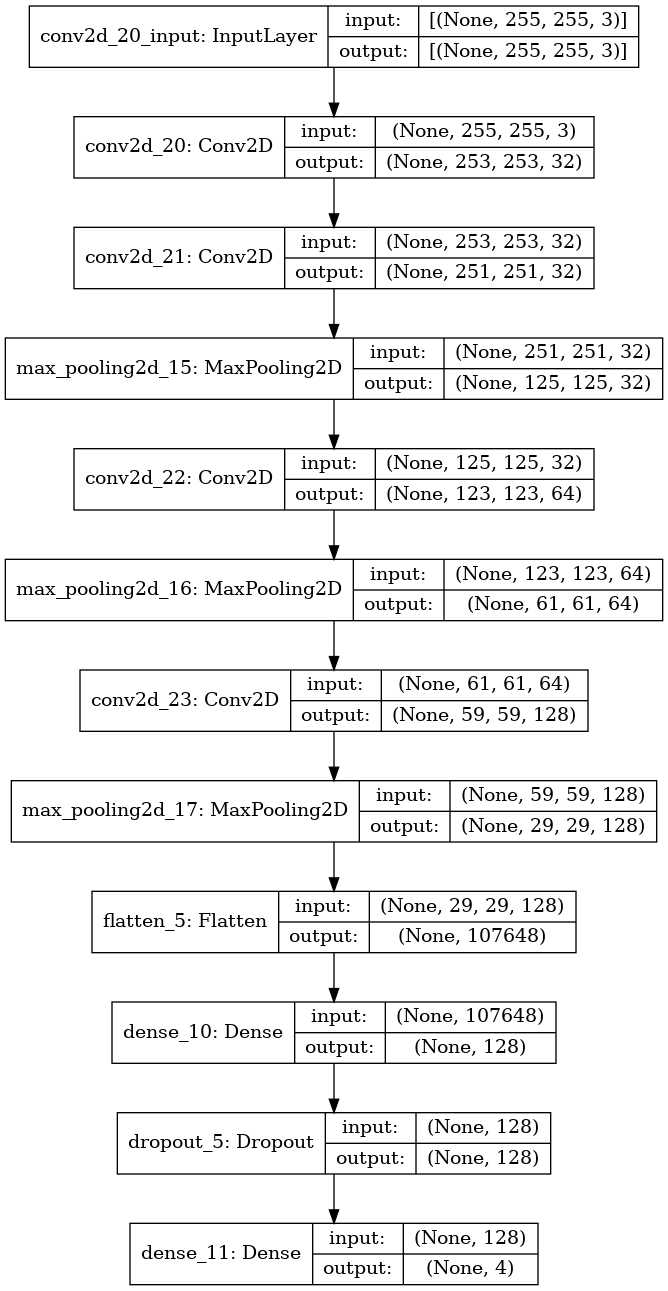

In [39]:
from tensorflow.keras.utils import plot_model
from PIL import Image

plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)
display(Image.open('cnn_model.png'))

# Loss & Accuracy Visualizations

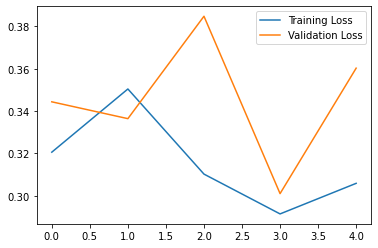

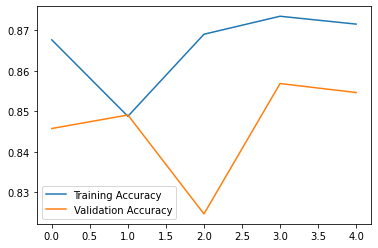

<Figure size 432x288 with 0 Axes>

In [40]:
# Plot the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# Plot the accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

# Saving Our Model

In [41]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the class names
class_names = ['Cloudy', 'Desert', 'Green_Area', 'Water']

In [42]:
# Load an image from the test set
img = load_img("/kaggle/input/satellite-image-classification/data/green_area/Forest_1768.jpg", target_size=(255, 255))

In [43]:
# Convert the image to an array
img_array = img_to_array(img)
img_array

array([[[32., 61., 67.],
        [32., 61., 67.],
        [32., 61., 67.],
        ...,
        [40., 64., 74.],
        [40., 64., 74.],
        [40., 64., 74.]],

       [[32., 61., 67.],
        [32., 61., 67.],
        [32., 61., 67.],
        ...,
        [40., 64., 74.],
        [40., 64., 74.],
        [40., 64., 74.]],

       [[32., 61., 67.],
        [32., 61., 67.],
        [32., 61., 67.],
        ...,
        [40., 64., 74.],
        [40., 64., 74.],
        [40., 64., 74.]],

       ...,

       [[33., 57., 67.],
        [33., 57., 67.],
        [33., 57., 67.],
        ...,
        [31., 58., 65.],
        [31., 58., 65.],
        [31., 58., 65.]],

       [[33., 57., 67.],
        [33., 57., 67.],
        [33., 57., 67.],
        ...,
        [31., 58., 65.],
        [31., 58., 65.],
        [31., 58., 65.]],

       [[33., 57., 67.],
        [33., 57., 67.],
        [33., 57., 67.],
        ...,
        [31., 58., 65.],
        [31., 58., 65.],
        [31., 58., 65.]]

In [44]:
img_array.shape

(255, 255, 3)

In [45]:
# Normalize the image pixel values to the range [0, 1]
img_array = img_array / 255.0
img_array

array([[[0.1254902 , 0.23921569, 0.2627451 ],
        [0.1254902 , 0.23921569, 0.2627451 ],
        [0.1254902 , 0.23921569, 0.2627451 ],
        ...,
        [0.15686275, 0.2509804 , 0.2901961 ],
        [0.15686275, 0.2509804 , 0.2901961 ],
        [0.15686275, 0.2509804 , 0.2901961 ]],

       [[0.1254902 , 0.23921569, 0.2627451 ],
        [0.1254902 , 0.23921569, 0.2627451 ],
        [0.1254902 , 0.23921569, 0.2627451 ],
        ...,
        [0.15686275, 0.2509804 , 0.2901961 ],
        [0.15686275, 0.2509804 , 0.2901961 ],
        [0.15686275, 0.2509804 , 0.2901961 ]],

       [[0.1254902 , 0.23921569, 0.2627451 ],
        [0.1254902 , 0.23921569, 0.2627451 ],
        [0.1254902 , 0.23921569, 0.2627451 ],
        ...,
        [0.15686275, 0.2509804 , 0.2901961 ],
        [0.15686275, 0.2509804 , 0.2901961 ],
        [0.15686275, 0.2509804 , 0.2901961 ]],

       ...,

       [[0.12941177, 0.22352941, 0.2627451 ],
        [0.12941177, 0.22352941, 0.2627451 ],
        [0.12941177, 0

In [46]:
import numpy as np
img_array = np.reshape(img_array, (1, 255, 255, 3))

# Using Our Model For Predictions

In [47]:
# Get the model predictions
predictions = model.predict(img_array)

In [48]:
# Get the class index with the highest predicted probability
class_index = np.argmax(predictions[0])

# Get the predicted class label
predicted_label = class_names[class_index]

print("The image is predicted to be '{}'.".format(predicted_label))

The image is predicted to be 'Green_Area'.


In [49]:
from sklearn.metrics import confusion_matrix
import numpy as np

In [50]:
predictions = model.predict(test_generator)

In [51]:
predictions

array([[4.0699530e-01, 5.9295195e-01, 5.9718542e-07, 5.2210726e-05],
       [9.9906427e-01, 3.4460498e-04, 8.7861727e-09, 5.9122156e-04],
       [9.9979419e-01, 2.0565606e-04, 1.3202961e-13, 1.2919043e-07],
       ...,
       [1.0980554e-03, 1.7686755e-08, 9.9188566e-01, 7.0162909e-03],
       [9.9936730e-01, 4.0214660e-04, 2.6224798e-09, 2.3055576e-04],
       [6.0397619e-04, 1.7352649e-09, 9.9794608e-01, 1.4499169e-03]],
      dtype=float32)

In [52]:
actual_labels = test_generator.classes

In [53]:
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels

array([1, 0, 0, ..., 2, 0, 2])

In [54]:
cm = confusion_matrix(actual_labels, predicted_labels)

In [55]:
print(cm)

[[ 98  74  93  63]
 [ 77  51  72  27]
 [ 84  53  95  52]
 [ 82  52 109  45]]


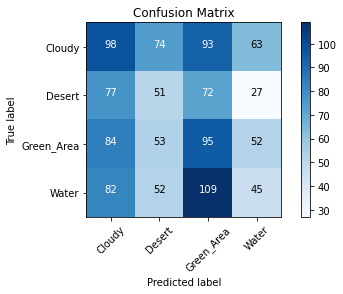

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Confusion matrix


# Plot the confusion matrix as an image
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Add the class labels to the plot
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add values to the plot
threshold = int(cm.mean())
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black")

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

# Advanced Predictions From URLs

In [57]:
from io import BytesIO
import requests
from tensorflow.keras.preprocessing import image
import numpy as np
import tempfile

# Define the class names
class_names = ['Cloudy', 'Desert', 'Green_Area', 'Water']

url_list = ['https://eoimages.gsfc.nasa.gov/images/imagerecords/92000/92263/goldstone_oli_2018124_lrg.jpg',
            'https://images.theconversation.com/files/258323/original/file-20190211-174861-jya1so.jpg?ixlib=rb-1.1.0&q=45&auto=format&w=1356&h=668&fit=crop',
            'https://img.freepik.com/free-photo/amazing-beautiful-sky-with-clouds_58702-1657.jpg?w=2000',
            'https://i.natgeofe.com/n/54c007c9-50e5-4cf5-83dc-978a35a4373a/68576_16x9.jpg',
           ]


for url in url_list:
    response = requests.get(url)
    with tempfile.NamedTemporaryFile(mode='wb') as f:
        f.write(response.content)
        f.seek(0)
        img = image.load_img(f.name, target_size=(255, 255))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)

        classes = model.predict(img, batch_size=10)
        class_index = np.argmax(classes[0])
        predicted_label = class_names[class_index]
        print(url + " The image is predicted to be '{}'.".format(predicted_label))


https://eoimages.gsfc.nasa.gov/images/imagerecords/92000/92263/goldstone_oli_2018124_lrg.jpg The image is predicted to be 'Desert'.
https://images.theconversation.com/files/258323/original/file-20190211-174861-jya1so.jpg?ixlib=rb-1.1.0&q=45&auto=format&w=1356&h=668&fit=crop The image is predicted to be 'Water'.
https://img.freepik.com/free-photo/amazing-beautiful-sky-with-clouds_58702-1657.jpg?w=2000 The image is predicted to be 'Cloudy'.
https://i.natgeofe.com/n/54c007c9-50e5-4cf5-83dc-978a35a4373a/68576_16x9.jpg The image is predicted to be 'Desert'.


# Table of results

In [59]:
trials = [
    trial1, trial2, trial3, trial4, trial5, trial6, 
    trial7, trial8, trial9, trial10, trial11,
    trial12, trial13, trial14, trial15
]
df_res = pd.DataFrame(columns=trials[0].keys())
for trial in trials:
    df_res.loc[len(df_res)] = trial

df_res = df_res.sort_values(by=['accuracy', 'loss', 'time_train', 'time_eval'], ascending=[False, True, True, True])
df_res

,optimizer,lr,loss,accuracy,batch_size,epochs,nn_architecture,time_eval,time_train
4,Adam,0.001,0.279745,0.889973,64,10,default,10.696552,695.351642
7,RMSprop,0.001,0.335388,0.881100,64,7,default,5.401373,501.063084
14,Adam,0.001,0.259070,0.871340,32,10,more_complex_with_GlobalAveragePooling2D,5.914342,712.969217
10,RMSprop,0.001,0.320658,0.871340,64,10,default,5.379925,675.313509
13,Adam,0.001,0.255807,0.869565,32,10,more_complex_with_flatten,6.298624,713.727845
0,Adam,0.001,0.330241,0.858917,32,7,default,10.197213,495.187849
6,RMSprop,0.001,0.324014,0.849157,32,7,default,5.623700,498.176972
1,Adam,0.001,0.383912,0.849157,64,7,default,5.413289,498.152158
8,RMSprop,0.001,0.399212,0.818101,32,10,default,5.669136,653.672870
2,Adam,0.001,0.421819,0.801242,32,10,default,4.638371,726.903415
